In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from plot_func.gen_distribution_single_plots import analyze_phases
from plot_func.gen_distribution_subplot import analyze_single_type    # plot_combined_results
from plot_func.gen_distribution_merged_plot import plot_merged


In [2]:
def get_output_dir(filename, start_time, end_time):
    """Create and return output directory path based on filename and time range"""
    # filename = os.path.splitext(os.path.basename(bvh_file))[0]
    dir_name = f"{filename}_{start_time:.1f}_{end_time:.1f}"
    output_dir = os.path.join("output_static_plot", dir_name)
    os.makedirs(output_dir, exist_ok=True)
    return output_dir

manjanin   = [0.035, 0.100, 0.200, 0.285, 0.350, 0.450, 0.535, 0.600, 0.700, 0.775, 0.850, 0.950]
suku       = [0.038, 0.105, 0.200, 0.288, 0.355, 0.450, 0.538, 0.605, 0.700, 0.788, 0.855, 0.950]
maraka     = [0.043, 0.123, 0.205, 0.293, 0.373, 0.455, 0.543, 0.623, 0.705, 0.793, 0.873, 0.955]
wasulunka  = [0.045, 0.123, 0.210, 0.295, 0.373, 0.460, 0.545, 0.623, 0.710, 0.795, 0.873, 0.960]
boundary_lines = {"manjanin": manjanin, "suku": suku, "maraka": maraka, "wasulunka": wasulunka}


In [ ]:
# #   BKO_E1_D1_02_Maraka   BKO_E1_D1_01_Suku
# #    BKO_E1_D1_06_Manjanin     BKO_E1_D2_05_Wasulunka

# # file_name = "BKO_E1_D2_05_Wasulunka"       
# cycles_csv_path = f"data/virtual_cycles/{file_name}_C.csv"
# onsets_csv_path = f"data/drum_onsets/{file_name}.csv"


# # pulse bin 03
# # manjanin   = [0.035,  0.105,  0.2,    0.285,  0.355,  0.45,   0.535,  0.6025, 0.7,    0.7675, 0.85,   0.9475]
# # suku       = [0.0375, 0.11,   0.2025, 0.2875, 0.3625, 0.4525, 0.5425, 0.61,   0.7025, 0.7875, 0.86,   0.9525]
# # maraka     = [0.0425, 0.1225, 0.2075, 0.2925, 0.3775, 0.4575, 0.5425, 0.6275, 0.705,  0.7925, 0.8725, 0.955 ]
# # wasulunka  = [0.045,  0.1225, 0.21,   0.29,   0.3775, 0.4575, 0.545,  0.625,  0.71,   0.79,   0.875,  0.9575]

# # pulse bin 04
# manjanin   = [0.035, 0.100, 0.200, 0.285, 0.350, 0.450, 0.535, 0.600, 0.700, 0.775, 0.850, 0.950]
# suku       = [0.038, 0.105, 0.200, 0.288, 0.355, 0.450, 0.538, 0.605, 0.700, 0.788, 0.855, 0.950]
# maraka     = [0.043, 0.123, 0.205, 0.293, 0.373, 0.455, 0.543, 0.623, 0.705, 0.793, 0.873, 0.955]
# wasulunka  = [0.045, 0.123, 0.210, 0.295, 0.373, 0.460, 0.545, 0.623, 0.710, 0.795, 0.873, 0.960]



# # piece = file_name.split("_")[-1].lower()
# boundary_lines = {"manjanin": manjanin, "suku": suku, "maraka": maraka, "wasulunka": wasulunka}

In [5]:
ls_virtual_cycles = os.listdir(f"data/virtual_cycles")
ls_drum_onsets = os.listdir(f"data/drum_onsets")

for file_name in ls_drum_onsets:
    piece = file_name.split("_")[-1].lower()[:-4]
    fname = file_name.split(".")[0]
    if piece in boundary_lines.keys(): 
        print(piece, fname)

        cycles_csv_path = f"data/virtual_cycles/{fname}_C.csv"
        onsets_csv_path = f"data/drum_onsets/{fname}.csv"
    break

suku BKO_E1_D1_01_Suku


## Stacked Plot with mean markers per Bin

In [3]:
def plot_merged_stacked(file_name,
                        cycles_csv_path,
                        onsets_csv_path,
                        boundary_marker,
                        W_start=None,
                        W_end=None,
                        figsize=(10, 12),
                        dpi=100,
                        use_window=True,
                        ):
    """Create a single plot showing merged analysis for Dun, J1, and J2
    with stacked, segment-colored scatter and combined KDE."""
    
    # 1) prepare bins & colors from boundary_marker (normalized 0–1)
    edges = [0.0] + boundary_marker + [1.0]
    n_bins = len(edges) - 1
    base_colors = plt.get_cmap('tab10').colors
    step = 3  # co-prime to 10 so adjacent segments differ
    segment_colors = [base_colors[(i*step) % len(base_colors)]
                      for i in range(n_bins)]
    
    # 2) define major xticks (0–400 in ~12 segments)
    xtick = [0, 33, 67, 100, 133, 167, 200, 233, 267, 300, 333, 367, 400]

    # 3) set up single merged axes
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    onset_types = ['Dun', 'J1', 'J2']
    colors      = ['blue', 'green', 'red']
    # vertical stacking ranges for each type
    vertical_ranges = {
        'Dun': (1, 6),    # y from 1–6
        'J1':  (8, 13),   # y from 8–13
        'J2':  (15, 20),  # y from 15–20
    }

    combined_h = None
    combined_xx = None
    
    # Dictionary to store all phases for each bin
    bin_phases = {i: [] for i in range(n_bins)}

    # 4) loop onset types, plot segment-colored scatter
    for onset_type, color in zip(onset_types, colors):
        phases, window_pos, kde_xx, kde_h = analyze_single_type(
            cycles_csv_path, onsets_csv_path,
            onset_type, W_start, W_end,
            use_window=use_window
        )
        if phases is None:
            continue

        # stack y
        y0, y1 = vertical_ranges[onset_type]
        y_scaled = y0 + (window_pos * (y1 - y0))

        # Handle phases for binning
        # For phases > last boundary, convert to negative values for bin 0
        phases_for_binning = phases.copy()
        phases_for_binning[phases > boundary_marker[-1]] -= 1.0

        # bin & clamp
        bin_idx = np.digitize(phases_for_binning, edges) - 1
        bin_idx = np.clip(bin_idx, 0, n_bins-1)

        # scatter each segment and collect phases
        for seg in range(n_bins):
            mask = bin_idx == seg
            if not np.any(mask):
                continue
                
            # Store phases for this bin
            bin_phases[seg].extend(phases[mask])
            
            # Plot scatter
            ax.scatter(phases[mask] * 400,
                       y_scaled[mask],
                       s=5, alpha=0.6,
                       color=segment_colors[seg])

        # accumulate KDE
        if combined_h is None:
            combined_h = kde_h.copy()
            combined_xx = kde_xx.copy()
        else:
            combined_h += kde_h

    # Calculate and plot means for each bin
    for seg in range(n_bins):
        if bin_phases[seg]:  # if bin has any phases
            mean_phase = np.mean(bin_phases[seg])
            # Draw mean line across all ranges
            ax.vlines(mean_phase * 400, -5, 20,      ###########################
                     color='black', linestyle='--', alpha=0.3)
            # Add mean label at top
            ax.text(mean_phase * 400, 20.5,
                   f'{mean_phase*400:.1f}',
                   rotation=45,
                   ha='center', va='bottom',
                   color='black',
                   fontsize=8)

    # 5) draw combined KDE at bottom (-5 to 0)
    if combined_h is not None:
        # normalize to 0–1
        combined_h = combined_h / np.max(combined_h)
        kde_scaled = -5 + (5 * combined_h)
        ax.fill_between(combined_xx * 400,
                        -5, kde_scaled,
                        alpha=0.3, color='purple',
                        label='Combined KDE')

    # 6) draw vertical boundary lines + labels
    for x0 in boundary_marker:
        x_pos = x0 * 400
        ax.vlines(x_pos, -5, 0,            ############################### 20.5
                  color='blue', linestyle='--', alpha=0.5)
        ax.text(x_pos, 1.02,         # y=1.02 in axis-fraction
                f"{x_pos:.0f}",
                rotation=45,
                ha='center', va='bottom',
                transform=ax.get_xaxis_transform(),
                clip_on=False,
                fontsize=8,
                color='blue')

    # 7) styling & axes
    ax.set_xlim(0, 400)
    ax.set_xticks(xtick)
    ax.set_xlabel('Metric cycle (0-400)')
    
    ax.set_ylim(-5.5, 20.5)
    ax.set_yticks([3, 10, 17])
    ax.set_yticklabels(['Dun', 'J1', 'J2'])
    
    ax.set_ylabel('Instrument')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-33, 400)

    # 8) title & legend
    title = f'File: {file_name}'
    title += f' | Window: {W_start:.1f}s - {W_end:.1f}s' if use_window else ' | Full Recording'
    ax.set_title(title, pad = 40)

    # ax.legend(loc='upper right', framealpha=0.7, fontsize='small')
    
    # plt.tight_layout()
    # plt.show()

    return fig, ax

## Plot full duration

Dun - Total onsets: 2821
J1 - Total onsets: 2821
J2 - Total onsets: 2821


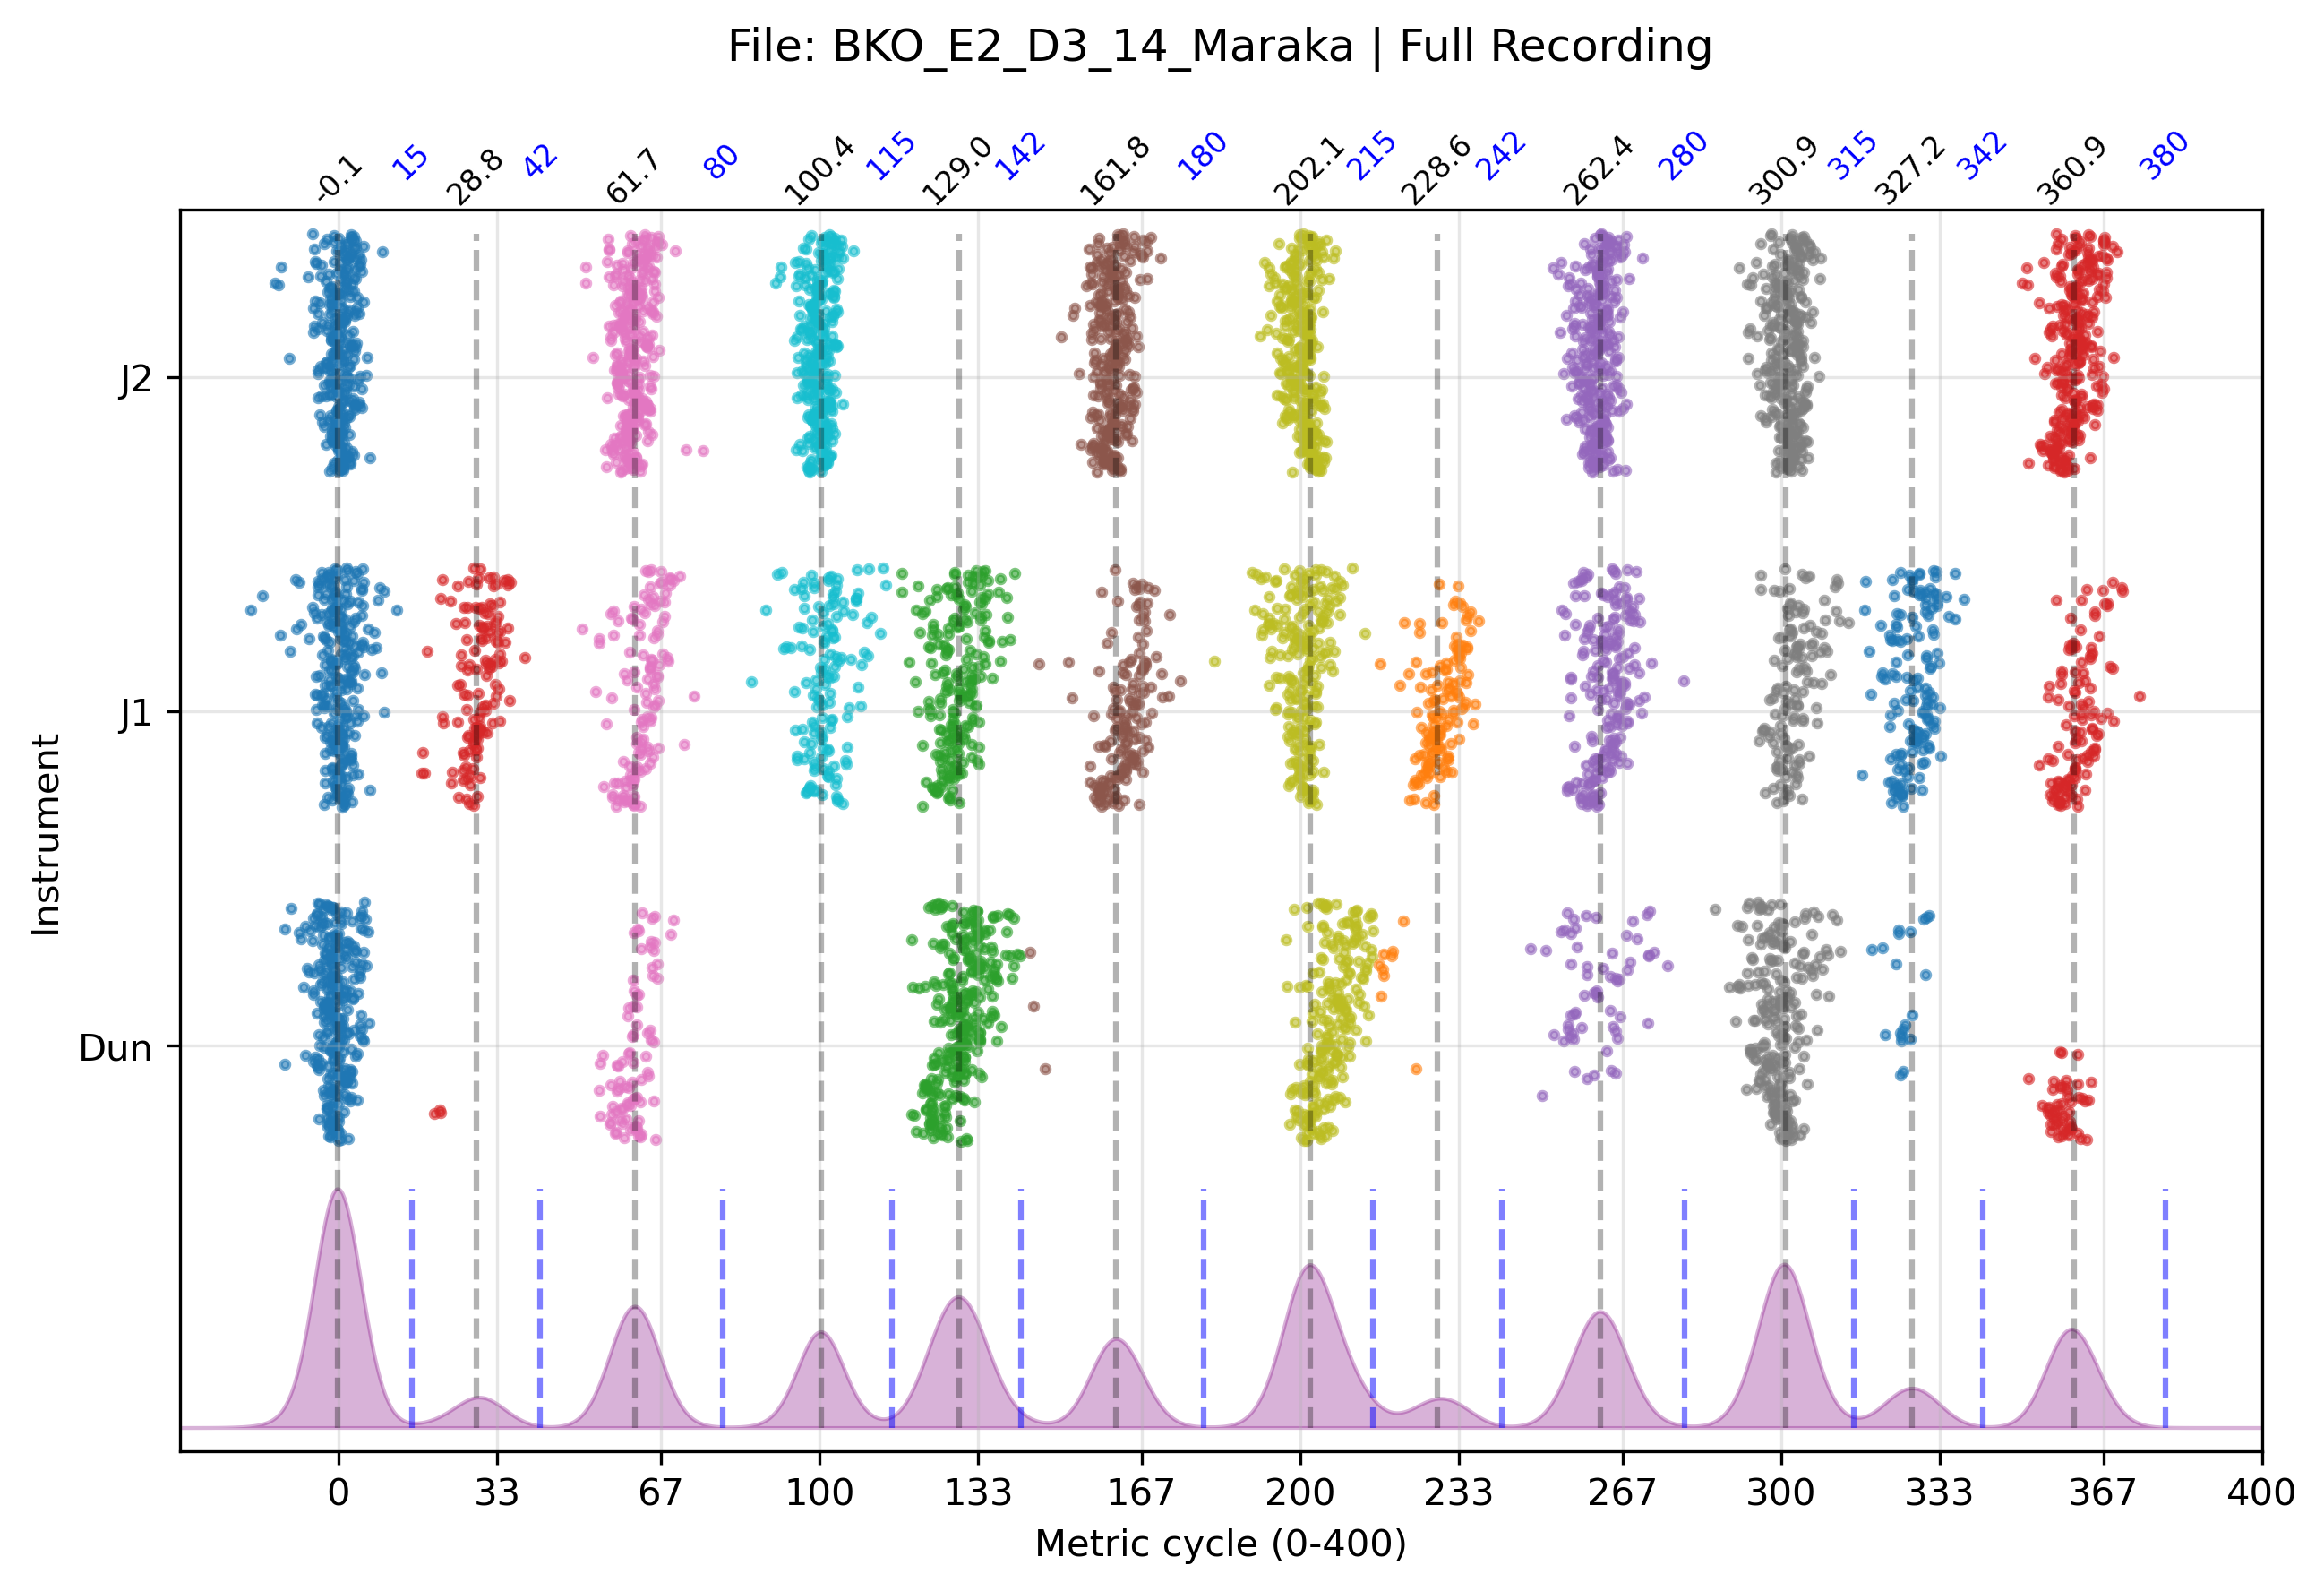

In [6]:
fig, _ = plot_merged_stacked("BKO_E2_D3_14_Maraka",
                        cycles_csv_path,
                        onsets_csv_path,
                        boundary_lines[piece],
                        W_start=0,
                        W_end=123,
                        figsize= (10, 6),
                        dpi=300,
                        use_window=False,
                        )
# save_path_window = os.path.join(static_save_dir, f"{file_name}_{W_start}_{W_end}__subplot.png")

plt.show(fig)
save_path_full = f"output_static_plot\\{file_name}_full_recording.png"
# fig.savefig(save_path_full, bbox_inches='tight', dpi=300)
# plt.close(fig)  # Close the figure to free memory 

## Per Recording Batch Process

In [ ]:
ls_virtual_cycles = os.listdir(f"data/virtual_cycles")
ls_drum_onsets = os.listdir(f"data/drum_onsets")

for file_name in ls_drum_onsets:
    piece = file_name.split("_")[-1].lower()[:-4]
    fname = file_name.split(".")[0]
    if piece in boundary_lines.keys(): 
        print(piece, fname)

        cycles_csv_path = f"data/virtual_cycles/{fname}_C.csv"
        onsets_csv_path = f"data/drum_onsets/{fname}.csv"


        fig, _ = plot_merged_stacked(fname,
                                cycles_csv_path,
                                onsets_csv_path,
                                boundary_lines[piece],
                                W_start=None,
                                W_end=None,
                                figsize= (10, 6),
                                dpi=300,
                                use_window=False,
                                )
        save_path_full = f"output_static_plot\\{fname}_full_recording.png"
        fig.savefig(save_path_full, bbox_inches='tight', dpi=300)

## Per Piece Batch Process

In [5]:
from plot_func.gen_distribution_single_plots import kde_estimate

# 1. Organize files by piece
piece_files = {}
ls_drum_onsets = os.listdir(f"data/drum_onsets")
for file_name in ls_drum_onsets:
    piece = file_name.split("_")[-1].lower()[:-4]
    fname = file_name.split(".")[0]
    if piece in boundary_lines.keys():
        if piece not in piece_files:
            piece_files[piece] = []
        piece_files[piece].append(fname)

# 2. Aggregate phases and KDEs for each piece
def aggregate_piece_data(piece, file_list):
    all_phases = {'Dun': [], 'J1': [], 'J2': []}
    all_kde = {'Dun': None, 'J1': None, 'J2': None}
    kde_xx = None

    for fname in file_list:
        cycles_csv_path = f"data/virtual_cycles/{fname}_C.csv"
        onsets_csv_path = f"data/drum_onsets/{fname}.csv"
        for onset_type in ['Dun', 'J1', 'J2']:
            phases, _, kde_xx_file, kde_h = analyze_single_type(
                cycles_csv_path, onsets_csv_path,
                onset_type, None, None,
                use_window=False
            )
            if phases is not None:
                all_phases[onset_type].extend(phases)
                if all_kde[onset_type] is None:
                    all_kde[onset_type] = kde_h
                else:
                    # Ensure KDEs are on the same grid
                    if len(kde_h) != len(all_kde[onset_type]):
                        kde_h = np.interp(np.linspace(0, 1, len(all_kde[onset_type])), 
                                          np.linspace(0, 1, len(kde_h)), kde_h)
                    all_kde[onset_type] += kde_h
                kde_xx = kde_xx_file  # Use the last one, they should all be the same

    return all_phases, all_kde, kde_xx

# 3. Plotting function
def plot_aggregated_piece(piece_name, all_phases, all_kde, kde_xx, boundary_marker, figsize=(10, 12), dpi=100):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    onset_types = ['Dun', 'J1', 'J2']
    colors = ['blue', 'green', 'red']
    vertical_ranges = {
        'Dun': (1, 6),
        'J1': (8, 13),
        'J2': (15, 20),
    }
    # Plot scatter for each onset type
    edges = [0.0] + boundary_marker + [1.0]
    n_bins = len(edges) - 1
    base_colors = plt.get_cmap('tab10').colors
    step = 3
    segment_colors = [base_colors[(i*step) % len(base_colors)] for i in range(n_bins)]
    bin_phases = {i: [] for i in range(n_bins)}

    ############# Plot scatter for each onset type, colored by bin
    for onset_type in onset_types:
        phases = np.array(all_phases[onset_type])
        if len(phases) == 0:
            continue
        y0, y1 = vertical_ranges[onset_type]
        y_positions = np.random.uniform(y0, y1, size=len(phases))
        # For binning, wrap phases > last boundary
        phases_for_binning = phases.copy()
        phases_for_binning[phases > boundary_marker[-1]] -= 1.0
        bin_idx = np.digitize(phases_for_binning, edges) - 1
        bin_idx = np.clip(bin_idx, 0, n_bins-1)
        for seg in range(n_bins):
            mask = bin_idx == seg
            if np.any(mask):
                ax.scatter(phases[mask] * 400, y_positions[mask],
                        s=5, alpha=0.6, color=segment_colors[seg])
                bin_phases[seg].extend(phases[mask])

    # Plot mean line and label for each bin
    for seg in range(n_bins):
        if bin_phases[seg]:
            mean_phase = np.mean(bin_phases[seg])
            ax.vlines(mean_phase * 400, -5, 20,
                    color='black', linestyle='--', alpha=0.5)
            ax.text(mean_phase * 400, 20.5,
                    f'{mean_phase*400:.1f}',
                    rotation=45,
                    ha='center', va='bottom',
                    color='black',
                    fontsize=8)
            
            
    ############# Plot combined KDE
    combined_kde = sum([k for k in all_kde.values() if k is not None])
    if np.max(combined_kde) > 0:
        combined_kde = combined_kde / np.max(combined_kde)
    kde_scaled = -5 + (5 * combined_kde)
    ax.fill_between(kde_xx * 400, -5, kde_scaled, alpha=0.3, color='purple', label='Combined KDE')
    # Plot bin borders
    for x0 in boundary_marker:
        x_pos = x0 * 400
        ax.vlines(x_pos, -5, 0, color='blue', linestyle='--', alpha=0.5)
        ax.text(x_pos, 1.02, f"{x_pos:.0f}", rotation=45, ha='center', va='bottom',
                transform=ax.get_xaxis_transform(), clip_on=False, fontsize=8, color='blue')
    # Styling
    ax.set_xlim(-33, 400)
    ax.set_ylim(-5.5, 20.5)
    ax.set_yticks([3, 10, 17])
    ax.set_yticklabels(['Dun', 'J1', 'J2'])
    ax.set_xlabel('Metric cycle (0-400)')
    ax.set_ylabel('Instrument')
    ax.grid(True, alpha=0.3)
    ax.set_title(f'Piece: {piece_name} | Aggregated across all recordings', pad=40)
    plt.tight_layout()
    return fig, ax

# 4. Main loop
for piece, file_list in piece_files.items():
    print(f"Processing piece: {piece}")
    all_phases, all_kde, kde_xx = aggregate_piece_data(piece, file_list)
    fig, _ = plot_aggregated_piece(piece, all_phases, all_kde, kde_xx, boundary_lines[piece],
                                   figsize=(10, 6), dpi=300)
    save_path = f"output_static_plot/{piece}_aggregated.png"
    fig.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close(fig)

Processing piece: suku
Dun - Total onsets: 2821
J1 - Total onsets: 2821
J2 - Total onsets: 2821
Dun - Total onsets: 1296
J1 - Total onsets: 1296
J2 - Total onsets: 1296
Dun - Total onsets: 1141
J1 - Total onsets: 1141
J2 - Total onsets: 1141
Dun - Total onsets: 1395
J1 - Total onsets: 1395
J2 - Total onsets: 1395
Dun - Total onsets: 1357
J1 - Total onsets: 1357
J2 - Total onsets: 1357
Dun - Total onsets: 2194
J1 - Total onsets: 2194
J2 - Total onsets: 2194
Dun - Total onsets: 1252
J1 - Total onsets: 1252
J2 - Total onsets: 1252
Dun - Total onsets: 999
J1 - Total onsets: 999
J2 - Total onsets: 999
Dun - Total onsets: 1525
J1 - Total onsets: 1525
J2 - Total onsets: 1525
Dun - Total onsets: 1653
J1 - Total onsets: 1653
J2 - Total onsets: 1653
Dun - Total onsets: 1647
J1 - Total onsets: 1647
J2 - Total onsets: 1647
Dun - Total onsets: 1773
J1 - Total onsets: 1773
J2 - Total onsets: 1773
Dun - Total onsets: 1640
J1 - Total onsets: 1640
J2 - Total onsets: 1640
Dun - Total onsets: 2641
J1 - T

## Plot for a time segment

In [61]:
# W_start = 0    
# W_end = 200
# static_save_dir = get_output_dir(file_name, W_start, W_end)

# figsize2 = (10, 9)  
# dpi2 = 200
# fig, _ = plot_combined_results(file_name, cycles_csv_path, onsets_csv_path, W_start, W_end, figsize=figsize2, dpi=dpi2)       


# save_path_window = os.path.join(static_save_dir, f"{file_name}_{W_start}_{W_end}__subplot.png")
# fig.savefig(save_path_window, bbox_inches='tight', dpi=dpi2)
# plt.close(fig)  # Close the figure to free memory 